In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = '/content/gdrive/MyDrive/aml_project/data/'

In [3]:
!ls /content/gdrive/MyDrive/aml_project/data/

articles.csv	 df_customers.pkl	    sample_submission.csv
customers.csv	 df_transactions_train.pkl  transactions_train.csv
df_articles.pkl  memory_reduction.png


In [4]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

helper functions

In [5]:
def load_pkl(fname):
    with open(fname, 'rb') as infile:
        return pickle.load(infile)
def save_pkl(df, fname):
    with open(fname, 'wb') as outfile:
        pickle.dump(df, outfile)
def na_percent(df):
    return df.isna().sum()/len(df)
def map_customer_id(df):
    df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
def map_article_id(df):
    df['article_id'] = df['article_id'].astype('int32')
    # when making predictions, should convert to string and add leading 0
    # e.g. train['article_id'] = '0' + train.article_id.astype('str')

load data

In [6]:
df_articles = pd.read_csv(path+"articles.csv")
df_customers = pd.read_csv(path+"customers.csv")
df_sample_submission = pd.read_csv(path+"sample_submission.csv")

In [7]:
df_transactions_train = pd.read_csv(path+"transactions_train.csv")

## df_articles

In [8]:
df_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [9]:
df_articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [10]:
na_percent(df_articles)

article_id                      0.000000
product_code                    0.000000
prod_name                       0.000000
product_type_no                 0.000000
product_type_name               0.000000
product_group_name              0.000000
graphical_appearance_no         0.000000
graphical_appearance_name       0.000000
colour_group_code               0.000000
colour_group_name               0.000000
perceived_colour_value_id       0.000000
perceived_colour_value_name     0.000000
perceived_colour_master_id      0.000000
perceived_colour_master_name    0.000000
department_no                   0.000000
department_name                 0.000000
index_code                      0.000000
index_name                      0.000000
index_group_no                  0.000000
index_group_name                0.000000
section_no                      0.000000
section_name                    0.000000
garment_group_no                0.000000
garment_group_name              0.000000
detail_desc     

In [11]:
map_article_id(df_articles)

In [12]:
df_articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [13]:
code_cols = ['article_id', 'product_code', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 
                 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']

In [14]:
df_articles = df_articles[code_cols]
df_articles.head()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,108775015,108775,253,1010016,9,4,5,1676,A,1,16,1002
1,108775044,108775,253,1010016,10,3,9,1676,A,1,16,1002
2,108775051,108775,253,1010017,11,1,9,1676,A,1,16,1002
3,110065001,110065,306,1010016,9,4,5,1339,B,1,61,1017
4,110065002,110065,306,1010016,10,3,9,1339,B,1,61,1017


In [15]:
save_pkl(df_articles, path+"df_articles.pkl")

## df_customers

In [16]:
df_customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [17]:
na_percent(df_customers)

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [18]:
map_customer_id(df_customers)

In [19]:
df_customers['FN'].unique()

array([nan,  1.])

In [20]:
df_customers['Active'].unique()

array([nan,  1.])

In [21]:
df_customers['FN'] = df_customers['FN'].fillna(0)
df_customers['Active'] = df_customers['Active'].fillna(0)

In [22]:
df_customers['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [23]:
ohe = OneHotEncoder()
encoded = ohe.fit_transform(df_customers[['club_member_status']]).toarray()

In [24]:
ohe.get_feature_names_out()

array(['club_member_status_ACTIVE', 'club_member_status_LEFT CLUB',
       'club_member_status_PRE-CREATE', 'club_member_status_nan'],
      dtype=object)

In [25]:
cmstatus = ['cmstatus_active', 'cmstatus_left', 'cmstatus_pre', 'cmstatus_na']
for i in range(4):
    df_customers[cmstatus[i]] = encoded[:, i]
del df_customers['club_member_status']

In [26]:
df_customers.fashion_news_frequency.value_counts()

NONE         877711
Regularly    477416
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

In [27]:
df_customers.fashion_news_frequency = df_customers.fashion_news_frequency.apply(lambda x:'NONE' if x=='None' else x)

In [28]:
oe = OrdinalEncoder(categories=[['NONE', 'Monthly', 'Regularly']], handle_unknown='use_encoded_value', unknown_value=-1)
encoded = oe.fit_transform(df_customers[['fashion_news_frequency']])

In [29]:
df_customers.fashion_news_frequency

0               NONE
1               NONE
2               NONE
3               NONE
4          Regularly
             ...    
1371975         NONE
1371976         NONE
1371977    Regularly
1371978    Regularly
1371979         NONE
Name: fashion_news_frequency, Length: 1371980, dtype: object

In [30]:
df_customers['fnfreq'] = encoded[:,0]
df_customers['fnfreq'].value_counts()

 0.0    877713
 2.0    477416
-1.0     16009
 1.0       842
Name: fnfreq, dtype: int64

In [31]:
del df_customers['fashion_news_frequency']

In [32]:
df_customers.head()

,customer_id,FN,Active,age,postal_code,cmstatus_active,cmstatus_left,cmstatus_pre,cmstatus_na,fnfreq
0,6883939031699146327,0.0,0.0,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.0,0.0,0.0,0.0,0.0
1,-7200416642310594310,0.0,0.0,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.0,0.0,0.0,0.0,0.0
2,-6846340800584936,0.0,0.0,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.0,0.0,0.0,0.0,0.0
3,-94071612138601410,0.0,0.0,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.0,0.0,0.0,0.0,0.0
4,-283965518499174310,1.0,1.0,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1.0,0.0,0.0,0.0,2.0


In [33]:
imp = SimpleImputer(strategy='mean')
df_customers['age'] = imp.fit_transform(df_customers[['age']])[:, 0]

In [34]:
df_customers.head()

,customer_id,FN,Active,age,postal_code,cmstatus_active,cmstatus_left,cmstatus_pre,cmstatus_na,fnfreq
0,6883939031699146327,0.0,0.0,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.0,0.0,0.0,0.0,0.0
1,-7200416642310594310,0.0,0.0,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.0,0.0,0.0,0.0,0.0
2,-6846340800584936,0.0,0.0,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.0,0.0,0.0,0.0,0.0
3,-94071612138601410,0.0,0.0,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.0,0.0,0.0,0.0,0.0
4,-283965518499174310,1.0,1.0,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1.0,0.0,0.0,0.0,2.0


In [35]:
na_percent(df_customers)

customer_id        0.0
FN                 0.0
Active             0.0
age                0.0
postal_code        0.0
cmstatus_active    0.0
cmstatus_left      0.0
cmstatus_pre       0.0
cmstatus_na        0.0
fnfreq             0.0
dtype: float64

In [36]:
save_pkl(df_customers, path+"df_customers.pkl")

## df_transactions_train

In [37]:
df_transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [38]:
na_percent(df_transactions_train)

t_dat               0.0
customer_id         0.0
article_id          0.0
price               0.0
sales_channel_id    0.0
dtype: float64

In [39]:
map_customer_id(df_transactions_train)
map_article_id(df_transactions_train)

In [40]:
df_transactions_train['t_dat'] = pd.to_datetime(df_transactions_train.t_dat)
df_transactions_train['year'] = (df_transactions_train.t_dat.dt.year-2000).astype('int8')
df_transactions_train['month'] = (df_transactions_train.t_dat.dt.month).astype('int8')
df_transactions_train['day'] = (df_transactions_train.t_dat.dt.day).astype('int8')
del df_transactions_train['t_dat']

In [41]:
df_transactions_train.head()

,customer_id,article_id,price,sales_channel_id,year,month,day
0,-6846340800584936,663713001,0.050831,2,18,9,20
1,-6846340800584936,541518023,0.030492,2,18,9,20
2,-8334631767138808638,505221004,0.015237,2,18,9,20
3,-8334631767138808638,685687003,0.016932,2,18,9,20
4,-8334631767138808638,685687004,0.016932,2,18,9,20


In [42]:
save_pkl(df_transactions_train, path+'df_transactions_train.pkl')

## Memory comparison

In [43]:
df_transactions_train = load_pkl(path+"df_transactions_train.pkl")
transactions_train_csv = pd.read_csv(path+"transactions_train.csv")

In [44]:
df_transactions_train.memory_usage(index=False, deep=True)

customer_id         254306592
article_id          127153296
price               254306592
sales_channel_id    254306592
year                 31788324
month                31788324
day                  31788324
dtype: int64

In [45]:
transactions_train_csv.memory_usage(index=False, deep=True)

t_dat               2129817708
customer_id         3846387204
article_id           254306592
price                254306592
sales_channel_id     254306592
dtype: int64

In [46]:
transactions_train_csv.memory_usage(index=False, deep=True).sum()

6739124688

In [47]:
6739124688/1024/1024/1024

6.276298955082893

In [48]:
df_transactions_train.memory_usage(index=False, deep=True).sum()/1024/1024/1024

0.9177606962621212

In [49]:
mem_diff = pd.DataFrame({"cols": ["customer_id", "customer_id", "article_id", "article_id", "t_dat", "t_dat"],
              "memory": [3846387204, 254306592, 254306592, 127153296, 2129817708, 95364972],
              "Status": ["before transformation", "after transformation", "before transformation", "after transformation", "before transformation", "after transformation"]})

In [50]:
mem_diff.memory = mem_diff.memory.apply(lambda x:round(x/(1024*1024), 2))

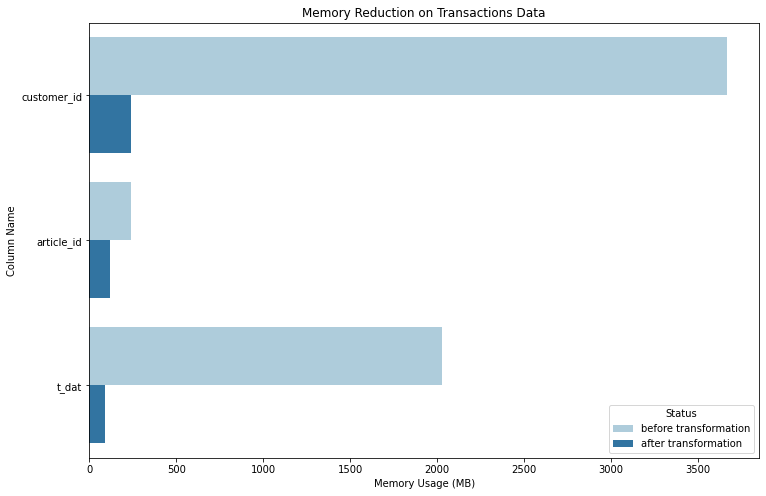

In [51]:
fig = plt.figure(figsize=(12,8))
sns.barplot(x="memory", y="cols", hue="Status", palette="Paired", data=mem_diff)
plt.title("Memory Reduction on Transactions Data")
plt.xlabel("Memory Usage (MB)")
plt.ylabel("Column Name")
plt.savefig(path+"memory_reduction.png")